# PROJECT-3. Анализ воронки
## Цель 
Исследовать поведение пользователей в обновлённом приложении.
## Проверяемые гипотезы
### *Гипотеза 1*
Существует ли разница в поведении групп, которые проходят и не проходят обучение? Влияет ли обучение на скорость прохождения других этапов игры?
### *Гипотеза 2*
Влияет ли повторное прохождение обучения, а также успешное завершение обучения, на оплату?
### *Гипотеза 3*
Проходит ли пользователь обучение, если сначала выбирает сложность?
## Формализованные задачи
1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности.
## Принятые исходные предпосылки
1. В анализе участвуют данные пользователей, зарегистрировавшихся в 2018 году (с 1 января по 31 декабря 2018 года включительно).
2. Для проверки 1 гипотезы пользователи разделены на 3 группы: 
- те, кто не проходил обучение; 
- те, кто начинал обучение и не закончил его; 
- те, кто начинал и завершал обучение.
3. Для проверки 2 гипотезы пользователи разделены на 2 группы:
- те, кто начинал обучение и ни разу не закончил его;
- те, кто начинал и завершил обучение хотя бы раз.

### Выполняем предобработку и очистку данных

In [1]:
# Импортируем библиотеки и читаем датасеты
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
Events = pd.read_csv('mod_44/Events.csv', sep = ',')
events_df = Events.copy()
Purchase = pd.read_csv('mod_44/Purchase.csv', sep = ',')
purchase_df = Purchase.copy()

In [2]:
# Переводим столбец с датой в формат datetime
events_df['start_time']=pd.to_datetime(events_df['start_time'], errors = 'coerce')
# Маска для пользователей, зарегистрировавшиеся в 2018 г.
mask1 = (events_df['start_time'] >= '2018-01-01') & (events_df['start_time'] < '2019-01-01') 
# Маска для фильтра пользователей с событием - регистрацией
mask2 = events_df['event_type'] == 'registration' 
# Список id пользователей, удовлетворяющих условиям масок
events_list = events_df[mask1 & mask2]['user_id'].to_list()
# Создаем датафрейм событий, в котором учитываются пользователи, зарегистрировавшиеся в 2018 г.
events_df = events_df[events_df['user_id'].isin(events_list)]
# Переименовываем столбец с id для удобства восприятия
events_df = events_df.rename(columns={"id": "event_id"}) 
# Удалим дубликаты строк, если они есть
events_df.drop_duplicates()
# Посмотрим на общую информацию по полученному датафрейму
display(events_df.info())
# В таблице встречаются пропущенные значения в столбцах "selected_level" и "tutorial_id",
# т.к. не все зарегистрировавшиеся пользователи выбирали обучение и уровень сложности
# Посмотрим какие типы событий встречаются 
display(events_df['event_type'].unique()) 

<class 'pandas.core.frame.DataFrame'>
Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  int64         
 1   event_type      66959 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      66959 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         66959 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.6+ MB


None

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice'], dtype=object)

In [3]:
# Создаем датафрейм оплат, в котором учитываются пользователи, зарегистрировавшиеся в 2018 г.
purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'], errors='coerce')
purchase_df = purchase_df[purchase_df['user_id'].isin(events_list)]
# Удалим дубликаты строк, если они есть
purchase_df.drop_duplicates()
# Добавим столбец в датафрейм по оплатам, который будет содержать значение оплаты для события
purchase_df['event_type'] = 'purchase'
# Оставим только нужные стоблцы для вычислений и переименуем столбец со временем
purchase_df = purchase_df[["user_id",'event_type', "event_datetime"]].rename(
    columns={"id": "purchase_id","event_datetime": "start_time"})
# Посмотрим на общую информацию по полученному датафрейму
display(purchase_df.info())
# Пропущенных значений в столбцах нет

<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 1171 to 2778
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     1600 non-null   int64         
 1   event_type  1600 non-null   object        
 2   start_time  1600 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 50.0+ KB


None

In [4]:
# Объединим два датафрейма для дальнейшей работы
total_events_df = pd.concat([events_df,purchase_df],sort=False, ignore_index=True)

### Гипотеза 1
Определим: существует ли разница в поведении групп, которые проходят и не проходят обучение. Влияет ли обучение на скорость прохождения других этапов игры.

In [5]:

# Создадим список всех уникальных id пользователей
all_users = total_events_df["user_id"].unique()
set_all_users = set(all_users)
display(f'Количество всех уникальных пользователей составляет {len(set_all_users)} чел.')
# Найдем пользователей, которые начинали и завершили обучение
users_with_finished_tutorial = total_events_df[total_events_df['event_type'] == 'tutorial_finish']["user_id"].unique()
set_users_with_finished_tutorial = set(users_with_finished_tutorial)
display(f'Количество пользователей, которые начинали и завершали обучение составляет {len(set_users_with_finished_tutorial)} чел.')
# Найдем пользователей, которые начинали и не завершили обучение
users_with_started_tutorial = total_events_df[total_events_df["event_type"] == "tutorial_start"]["user_id"].unique()
set_users_with_started_tutorial = set(users_with_started_tutorial)
set_users_not_finished_but_started_tutorial = (set_users_with_started_tutorial.difference(set_users_with_finished_tutorial))
display(f'Количество пользователей, которые начинали и не завершали ни разу обучение составляет {len(set_users_not_finished_but_started_tutorial)} чел.')
# Найдем пользователей, которые не начинали обучение
set_users_not_started_tutorial = set_all_users.difference(set_users_with_started_tutorial)
display(f'Количество пользователей, которые не начинали обучение составляет {len(set_users_not_started_tutorial)} чел.')
# Проверяем сходится ли общее количество пользователей
len(set_all_users) == len(set_users_with_finished_tutorial) + len(set_users_not_finished_but_started_tutorial) + len(set_users_not_started_tutorial)

'Количество всех уникальных пользователей составляет 19926 чел.'

'Количество пользователей, которые начинали и завершали обучение составляет 10250 чел.'

'Количество пользователей, которые начинали и не завершали ни разу обучение составляет 1608 чел.'

'Количество пользователей, которые не начинали обучение составляет 8068 чел.'

True

In [6]:
# Создадим функцию для присваивания пользователям группы: закончившие, не закончившие и не начинавшие обучение
def get_group(id):
    if id in set_users_not_finished_but_started_tutorial:
        return 'started_tutorial'
    elif id in set_users_with_finished_tutorial:
        return 'finished_tutorial'
    else:
        return 'not_started_tutorial'
# Создадим дополнительный столбец принадлежности пользователей к группам
total_events_df['group'] = total_events_df['user_id'].apply(get_group)
# Создадим сводную таблицу с минимальным временем совершения события
user_time_event = total_events_df.pivot_table(values='start_time', index=['user_id','group'], columns='event_type', aggfunc=min)
user_time_event = user_time_event.reset_index()
# Создадим дополнительные столбцы разницы времени между событиями 
user_time_event['finish-start_tutorial'] = user_time_event['tutorial_finish'] - user_time_event['tutorial_start']
user_time_event['level-reg'] = user_time_event['level_choice'] - user_time_event['registration']
user_time_event['pack-level'] = user_time_event['pack_choice'] - user_time_event['level_choice']
user_time_event['purchase-pack'] = user_time_event['purchase'] - user_time_event['pack_choice']
user_delta_time = user_time_event.groupby('group')[['level-reg','pack-level','purchase-pack']].mean().reset_index()
display(user_delta_time)

event_type,group,level-reg,pack-level,purchase-pack
0,finished_tutorial,0 days 07:05:36.854819357,0 days 00:05:18.146058732,3 days 17:17:59.641326883
1,not_started_tutorial,0 days 05:15:33.122448979,0 days 00:05:23.824324324,4 days 04:49:33.590909090
2,started_tutorial,0 days 08:12:57.551816958,0 days 00:05:05.295687885,3 days 21:14:46.908396946


In [7]:
# Оценим сколько времени в среднем уходит на обучение у пользователей
time_delta_tutorial = user_time_event['finish-start_tutorial'].mean()
time_delta_tutorial_minute = round(time_delta_tutorial / pd.Timedelta('1 minute'))
display(f'В среднем у пользователей на обучение уходит {time_delta_tutorial_minute} минут')

'В среднем у пользователей на обучение уходит 12 минут'

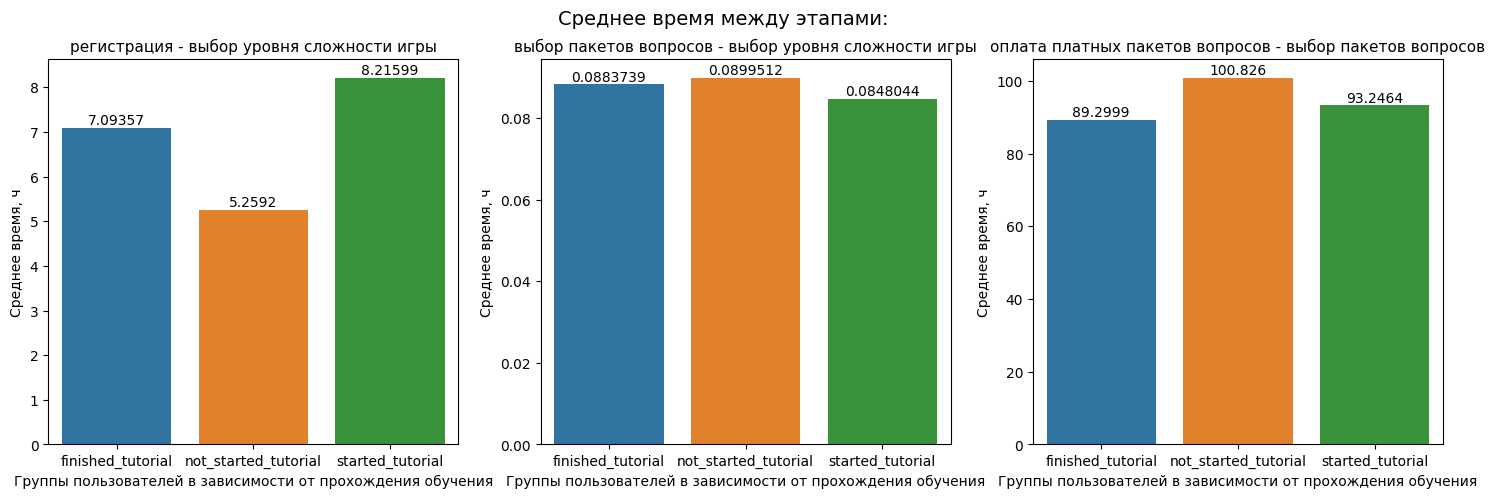

In [8]:
# Переведем интервалы в числовой формат для построения диаграмм
user_time_event['level-reg'] = user_time_event['level-reg'] / pd.Timedelta('1 hour')
user_time_event['pack-level'] = user_time_event['pack-level'] / pd.Timedelta('1 hour')
user_time_event['purchase-pack'] = user_time_event['purchase-pack'] / pd.Timedelta('1 hour')
user_delta_time = user_time_event.groupby('group')[['level-reg','pack-level','purchase-pack']].mean().reset_index()
# Построим столбчатые диаграммы для групп пользователей и оценим разницу по времени прохождения этапов
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,5))
fig.suptitle('Среднее время между этапами:', fontsize = 14)
# Диаграмма для этапов: выбор уровня сложности - регистрация
barplot = sns.barplot(data = user_delta_time, ax = axes[0], x = 'group', y = 'level-reg')
axes[0].set_title('регистрация - выбор уровня сложности игры', fontsize = 11)
axes[0].set_xlabel('Группы пользователей в зависимости от прохождения обучения')
axes[0].set_ylabel('Среднее время, ч')
axes[0].bar_label(barplot.containers[0]);
# Диаграмма для этапов: выбор пакетов вопросов - выбор уровня сложности
barplot = sns.barplot(data = user_delta_time, ax = axes[1], x = 'group', y = 'pack-level')
axes[1].set_title('выбор пакетов вопросов - выбор уровня сложности игры', fontsize = 11)
axes[1].set_xlabel('Группы пользователей в зависимости от прохождения обучения')
axes[1].set_ylabel('Среднее время, ч')
axes[1].bar_label(barplot.containers[0]);
# Диаграмма для этапов: покупка платных пакетов вопросов - выбор пакетов вопросов
barplot = sns.barplot(data = user_delta_time, ax = axes[2], x = 'group', y = 'purchase-pack')
axes[2].set_title('оплата платных пакетов вопросов - выбор пакетов вопросов', fontsize = 11)
axes[2].set_xlabel('Группы пользователей в зависимости от прохождения обучения')
axes[2].set_ylabel('Среднее время, ч')
axes[2].bar_label(barplot.containers[0]);

### Выводы по 1 гипотезе
1. Меньше всего времени от регистрации до выбора уровня сложности проходит у пользователей, не начинавших обучение (чуть больше 5 часов). Больше всего времени проходит для пользователей, начинавших и не закончивших обучение (чуть больше 8 часов). У пользователей, которые завершили обучение, время между этапами составляет 7 часов. Можно было бы предположить, что на данный показатель влияет время, потраченное на обучение, но согласно анализу среднее время прохождения обучения составляет всего 12 мин. А разница во времени между пользователями, проходившими и не проходившими обучение, около 2 часов, т.е. дело не в прохождении обучения. 
2. На время прохождения этапа от выбора уровня сложности до бесплатных пакетов вопросов прохождение обучения пользователями не влияет. Среднее время больше 5 мин для всех групп.
3. Время прохождения этапа от выбора бесплатных пакетов вопросов до покупки платных пакетов меньше у пользователей, которые завершили обучение (3 дня 17 часов). Чуть больше времени необходимо для пользоваталей начавших и не закончивших обучение (3 дня 21 час). Больше всего времени проходит для группы пользователей, которые не начинали обучение (почти 4 дня 5 часов). Можно сделать вывод, что обучение положительно влияет на покупку платных пакетов вопросов, даже если оно не было завершено.
4. В целом, можно предположить, что пользователи, не начинавшие обучение, стремятся быстрее приступить к выбору уровня сложности и выбору бесплатных вопросов, но они менее заинтересованы в покупке платных пакетов вопросов. В то время как пользователи, начинавшие или закончившие обучение, покупают платные пакеты вопросов примерно через равные интервалы времени. Более значимым показателем является сокращение времени до покупки платных пакетов вопросов (разница более 1 дня) между группами пользователей, т.к. разница во времени между регистрацией и выбором уровня сложности составляет около 2 часов, а между выбором уровней сложности и пакетов бесплатных вопросов примерно одинаковая.

### Гипотеза 2
Определим: влияет ли повторное прохождение обучения, а также успешное завершение обучения, на оплату.

In [9]:
# Разделим пользователей на 2 группы: тех, кто хоть раз завершил обучение и тех, кто не завершил обучение ни разу
# Вспомним из предыдущей гипотезы количество обучающихся пользователей:
# Количество всех пользователей, которые начинали обучение
display(f'Количество пользователей, которые начинали обучение составляет {len(set_users_with_started_tutorial)} чел.')
# Количество пользователей, которые завершили обучение
display(f'Количество пользователей, которые завершали хоть раз обучение составляет {len(set_users_with_finished_tutorial)} чел.')
# Количество пользователей, которые начинали и не закончили обучение
display(f'Количество пользователей, которые начинали и не завершали ни разу обучение составляет {len(set_users_not_finished_but_started_tutorial)} чел.')

'Количество пользователей, которые начинали обучение составляет 11858 чел.'

'Количество пользователей, которые завершали хоть раз обучение составляет 10250 чел.'

'Количество пользователей, которые начинали и не завершали ни разу обучение составляет 1608 чел.'

In [10]:
# Проанализируем количество стартов событий для каждого пользователя создав сводную таблицу
pivot_tutorial_start = total_events_df.pivot_table(values='start_time', index=['user_id'], columns='event_type', aggfunc='count')
pivot_tutorial_start = pivot_tutorial_start.reset_index()
# Оставим только необходимые столбцы для подсчета количества пользователей, начавших и завершивших хоть один раз обучение 
# и оплативших платные вопросы, сгруппируем по количеству стартов обучения
group_tutorial_finish = pivot_tutorial_start.groupby('tutorial_start')[['tutorial_finish','purchase']].count()
# Добавим столбец и вычислим в нем процент оплативших платные пакеты вопросов
group_tutorial_finish['persent'] = round(group_tutorial_finish['purchase']*100 / group_tutorial_finish['tutorial_finish'],1)
display(group_tutorial_finish)


event_type,tutorial_finish,purchase,persent
tutorial_start,,,
1.0,7548,1207,16.0
2.0,1538,218,14.2
3.0,425,51,12.0
4.0,221,30,13.6
5.0,109,16,14.7
6.0,116,14,12.1
7.0,94,12,12.8
8.0,86,13,15.1
9.0,113,17,15.0


In [11]:
# Оставим только необходимые столбцы для подсчета количества пользователей, не завершивших хоть один раз обучение 
# и оплативших платные вопросы, сгруппируем по количеству стартов обучения
group_tutorial_start = pivot_tutorial_start[pivot_tutorial_start['user_id'].isin(set_users_not_finished_but_started_tutorial)].groupby('tutorial_start')[['tutorial_start','purchase']].count()
# Добавим столбец и вычислим в нем процент оплативших платные пакеты вопросов
group_tutorial_start['persent'] = round(group_tutorial_start['purchase']*100 / group_tutorial_start['tutorial_start'],1)
display(group_tutorial_start)

event_type,tutorial_start,purchase,persent
tutorial_start,,,
1.0,1555,124,8.0
2.0,51,7,13.7
3.0,2,0,0.0


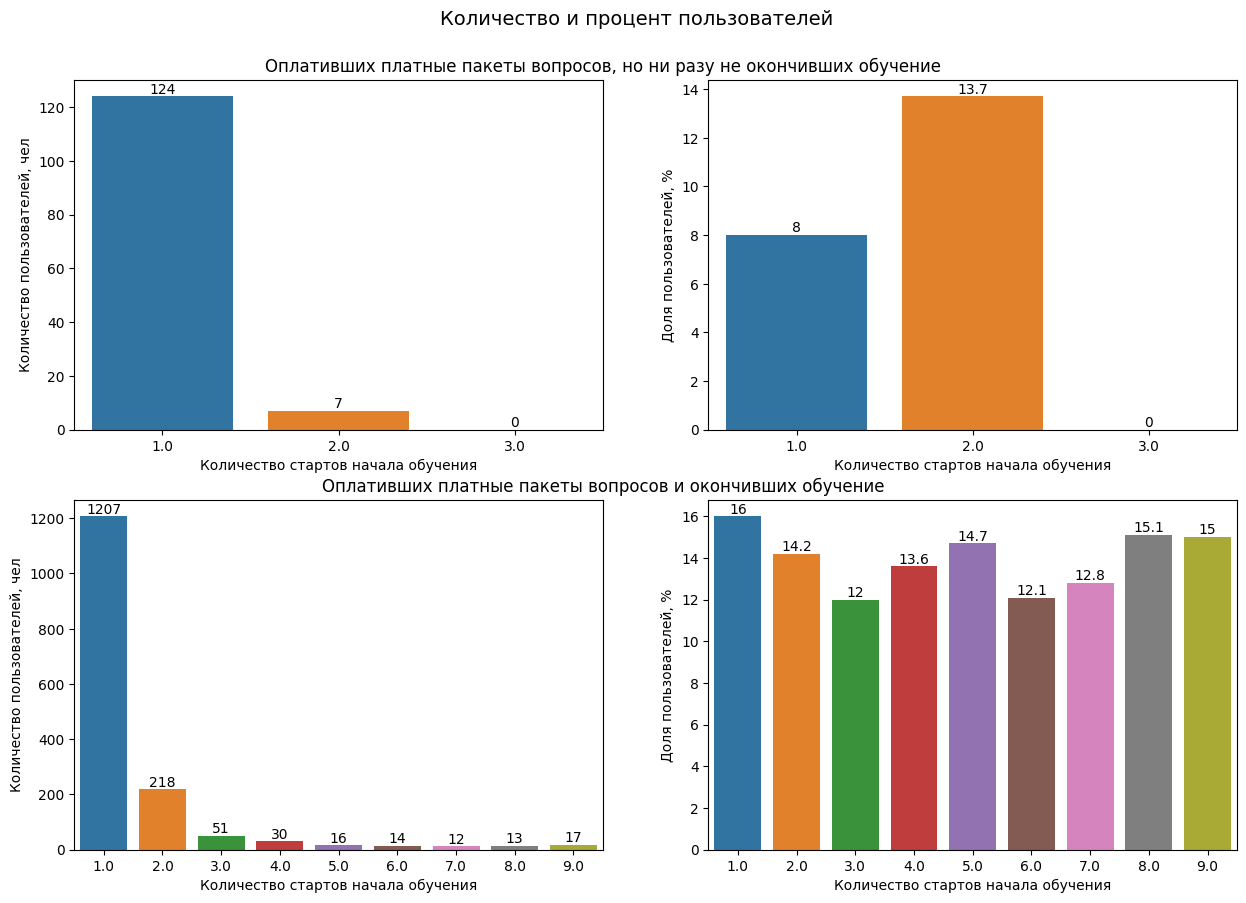

In [12]:
# Построим столбчатую диаграмму распределения количества пользователей
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.suptitle('Количество и процент пользователей', fontsize = 14, y = 0.95)
barplot = sns.barplot(data = group_tutorial_start, ax = axes[0][0], x = group_tutorial_start.index, y = 'purchase')
axes[0][0].set_title('Оплативших платные пакеты вопросов, но ни разу не окончивших обучение', fontsize = 12, x = 1)
axes[0][0].set_xlabel('Количество стартов начала обучения')
axes[0][0].set_ylabel('Количество пользователей, чел')
axes[0][0].bar_label(barplot.containers[0])
barplot = sns.barplot(data = group_tutorial_finish, ax = axes[1][0], x = group_tutorial_finish.index, y = 'purchase')
axes[1][0].set_title('Оплативших платные пакеты вопросов и окончивших обучение', fontsize = 12, x = 1)
axes[1][0].set_xlabel('Количество стартов начала обучения')
axes[1][0].set_ylabel('Количество пользователей, чел')
axes[1][0].bar_label(barplot.containers[0])
barplot = sns.barplot(data = group_tutorial_start, ax = axes[0][1], x = group_tutorial_start.index, y = 'persent')
axes[0][1].set_xlabel('Количество стартов начала обучения')
axes[0][1].set_ylabel('Доля пользователей, %')
axes[0][1].bar_label(barplot.containers[0])
barplot = sns.barplot(data = group_tutorial_finish, ax = axes[1][1], x = group_tutorial_finish.index, y = 'persent')
axes[1][1].set_xlabel('Количество стартов начала обучения')
axes[1][1].set_ylabel('Доля пользователей, %')
axes[1][1].bar_label(barplot.containers[0]);

### Выводы по 2 гипотезе
1. Исходя из проведенного анализа и диаграмм, явно отмечается положительное влияние завершения обучения на покупку платных пакетов вопросов. Независимо от количества стартов обучения процент пользователей, оплативших платные пакеты составляет 12-16%. Это может говорить о заинтересованности в прохождении обучения до конца, несмотря на повторные старты.
2. Наблюдается сильная разница в количестве пользователей с одним стартом обучения и бОльшим количество раз (отличие в 6 раз и более). При этом в процентном соотношении такой разницы между группами не наблюдается.
3. У пользователей, которые один раз начинали обучение и не завершили до конца, низкий показатель покупки платных вопросов. При этом те, кто второй раз начинал обучение покупают платные пакеты вопросов примерно в таком же процентном соотношении, что и закончившие обучение. Но в данной категории малое количество пользователей, чтобы объективно оценивать показатель. Также отметим, что те, кто начинал обучение третий раз, не совершают покупок платных вопросов, а также больше не начинают обучение заново, т.е. интерес у данной категории пользователей к платному продукту отсутствует.
4. В целом можно отметить достаточно большое количество пользователей, которые проходят обучение полностью с первого раза. Но при этом процент покупки платных пакетов вопросов не зависит от количества стартов обучения, главным критерияем является то, чтобы обучение было завершено. 

### Гипотеза 3
Определим: проходит ли пользователь обучение, если сначала выбирает сложность

In [13]:
# Найдем число пользователей, выбравших уровень сложности
level_choice_users_count=events_df[events_df['event_type'] == 'level_choice']['user_id'].nunique()
display(f'Количество пользователей, выбравших уровни сложности игры, составляет {level_choice_users_count} чел.')
# Создадим объединенную таблицу, в которой учтем тех, кто выбирал уровни сложности 
# Переименуем столбец с временем выбора уровня и соединим по user_id с таблицей проходивших обучение
# Так мы учтем тех, кто возвращался повторно к обучению после выбора уровней сложности
level_choice_df = total_events_df[total_events_df['event_type'] == 'level_choice'][['user_id', 'start_time']].rename(columns={'start_time':'level_choice_time'})
start_tutorial_df = total_events_df[total_events_df['event_type'] == 'tutorial_start'][['user_id', 'start_time']]
total_events_level_choice_df = level_choice_df.merge(start_tutorial_df, on = 'user_id', how='left')
total_events_level_choice_df
# Создадим дополнительный столбец и найдем разницу во времени между выбором уровня сложности и началом обучения
total_events_level_choice_df['delta'] = total_events_level_choice_df['level_choice_time'] - total_events_level_choice_df['start_time']
# Найдем количество пользователей, которые выбрали обучение до выбора уровней сложности
count_user_first_tutorial = total_events_level_choice_df[total_events_level_choice_df['delta'] > pd.Timedelta('1 sec')]['user_id'].nunique()
display(f'Количество пользователей, выбравших обучение до выбора уровней сложности, составляет {count_user_first_tutorial} чел.')
# Найдем количество пользователей, которые выбрали уровни сложности до обучения
count_user_first_level_choice = total_events_level_choice_df[total_events_level_choice_df['delta'] < pd.Timedelta('0')]['user_id'].nunique()
display(f'Количество пользователей, выбравших уровни сложности игры до обучения, составляет {count_user_first_level_choice} чел.')
# Вычислим процент пользователей, возвращавшихся к обучению от общего числа выбравших уровни сложности игры
persent_user_level = round(count_user_first_level_choice*100 / level_choice_users_count, 2)
display(f'Процент пользователей, выбравших уровни сложности игры до обучения, составляет {persent_user_level} % от общего числа пользователей, выбравших уровни сложности')

'Количество пользователей, выбравших уровни сложности игры, составляет 8342 чел.'

'Количество пользователей, выбравших обучение до выбора уровней сложности, составляет 8244 чел.'

'Количество пользователей, выбравших уровни сложности игры до обучения, составляет 1386 чел.'

'Процент пользователей, выбравших уровни сложности игры до обучения, составляет 16.61 % от общего числа пользователей, выбравших уровни сложности'

In [14]:
# Оценим сколько пользователей так и не завершили обучение даже вернувшись к нему после выбора уровня сложности
set_user_first_level_choice = set(total_events_level_choice_df[total_events_level_choice_df['delta'] < pd.Timedelta('0')]['user_id'].unique())
set_user_first_level_choice_and_not_finish = set_user_first_level_choice.difference(set_users_with_finished_tutorial)
count_user_first_level_choice_and_not_finish= int(len(set_user_first_level_choice_and_not_finish))
persent_first_level_choice_and_not_finish = round(count_user_first_level_choice_and_not_finish*100 / count_user_first_level_choice)
display(f'Количество пользователей, которые ни разу не завершили обучение и сначала выбирали уровни сложности составляет {count_user_first_level_choice_and_not_finish} чел. и {persent_first_level_choice_and_not_finish} % от общего числа, выбравших сначала уровни сложности игры')

'Количество пользователей, которые ни разу не завершили обучение и сначала выбирали уровни сложности составляет 18 чел. и 1 % от общего числа, выбравших сначала уровни сложности игры'

### Выводы по 3 гипотезе
1. Доля пользователей, вернувшихся к обучению после выбора уровней сложности игры составляет 16,6%. Показатель не критичный, но можно подумать над улучшением взаимодействия пользователей с игрой, доработать интерфейс, сделать интуитивно понятный функционал.
2. Можем отметить тот факт, что часть пользователей сначала выбирала обучение, затем уровни сложности, а затем повторно возвращалась к обучению. Количество пользователей, которые ни разу не завершили обучение и сначала выбирали уровни сложности составляет 18 чел. (около 1%) от всех, кто возвращался к обучению. Можно сделать вывод, что при обучении после выбора уровней сложности игры пользователи более заинтересованы в прохождении обучения.

## Итоговые выводы
### Выводы по 1 гипотезе
1. Меньше всего времени от регистрации до выбора уровня сложности проходит у пользователей, не начинавших обучение (чуть больше 5 часов). Больше всего времени проходит для пользователей, начинавших и не закончивших обучение (чуть больше 8 часов). У пользователей, которые завершили обучение, время между этапами составляет 7 часов. Можно было бы предположить, что на данный показатель влияет время, потраченное на обучение, но согласно анализу среднее время прохождения обучения составляет всего 12 мин. А разница во времени между пользователями, проходившими и не проходившими обучение, около 2 часов, т.е. дело не в прохождении обучения. 
2. На время прохождения этапа от выбора уровня сложности до бесплатных пакетов вопросов прохождение обучения пользователями не влияет. Среднее время больше 5 мин для всех групп.
3. Время прохождения этапа от выбора бесплатных пакетов вопросов до покупки платных пакетов меньше у пользователей, которые завершили обучение (3 дня 17 часов). Чуть больше времени необходимо для пользоваталей начавших и не закончивших обучение (3 дня 21 час). Больше всего времени проходит для группы пользователей, которые не начинали обучение (почти 4 дня 5 часов).
4. В целом можно предположить, что пользователи, не начинавшие обучение, стремятся быстрее приступить к выбору уровня сложности и выбору бесплатных вопросов, но они менее заинтересованы в покупке платных пакетов вопросов. В то время как пользователи, начинавшие или закончившие обучение, покупают платные пакеты вопросов примерно через равные интервалы времени. Более значимым показателем является сокращение времени до покупки платных пакетов вопросов (разница более 1 дня) между группами пользователей, т.к. разница во времени между регистрацией и выбором уровня сложности составляет около 2 часов, а между выбором уровней сложности и пакетов бесплатных вопросов примерно одинаковая.
### Выводы по 2 гипотезе
1. Исходя из проведенного анализа и диаграмм, явно отмечается положительное влияние завершения обучения на покупку платных пакетов вопросов. Независимо от количества стартов обучения процент пользователей, оплативших платные пакеты составляет 12-16%. Это может говорить о заинтересованности в прохождении обучения до конца, несмотря на повторные старты.
2. Наблюдается сильная разница в количестве пользователей с одним стартом обучения и бОльшим количество раз (отличие в 6 раз и более). При этом в процентном соотношении такой разницы между группами не наблюдается.
3. У пользователей, которые один раз начинали обучение и не завершили до конца, низкий показатель покупки платных вопросов. При этом те, кто второй раз начинал обучение покупают платные пакеты вопросов примерно в таком же процентном соотношении, что и закончившие обучение. Но в данной категории малое количество пользователей, чтобы объективно оценивать показатель. Также отметим, что те, кто начинал обучение третий раз, не совершают покупок платных вопросов, а также больше не начинают обучение заново, т.е. интерес у данной категории пользователей к платному продукту отсутствует.
4. В целом, можно отметить достаточно большое количество пользователей, которые проходят обучение полностью с первого раза. Но при этом процент покупки платных пакетов вопросов не зависит от количества стартов обучения, главным критерияем является то, чтобы обучение было завершено. 
### Выводы по 3 гипотезе
1. Доля пользователей, вернувшихся к обучению после выбора уровней сложности игры составляет 16,6%. Показатель не критичный, но можно подумать над улучшением взаимодействия пользователей с игрой, доработать интерфейс, сделать интуитивно понятный функционал.
2. Можем отметить тот факт, что часть пользователей сначала выбирала обучение, затем уровни сложности, а затем повторно возвращалась к обучению. Количество пользователей, которые ни разу не завершили обучение и сначала выбирали уровни сложности составляет 18 чел. (около 1%) от всех, кто возвращался к обучению. Можно сделать вывод, что при обучении после выбора уровней сложности игры пользователи более заинтересованы в прохождении обучения.
### Общие выводы
1. Меньше всего времени от регистрации до выбора уровня сложности проходит у пользователей, не начинавших обучение (чуть больше 5 часов). На время прохождения этапа от выбора уровня сложности до бесплатных пакетов вопросов прохождение обучения пользователями не влияет. Время прохождения этапа от выбора бесплатных пакетов вопросов до покупки платных пакетов меньше у пользователей, которые завершили обучение (3 дня 17 часов). В целом, обучение положительно влияет на покупку платных пакетов вопросов, даже если оно не было завершено. 
2. Отмечается положительное влияние завершения обучения на покупку платных пакетов вопросов. Независимо от количества стартов обучения процент пользователей, оплативших платные пакеты составляет 12-16%.
3. Доля пользователей, вернувшихся к обучению после выбора уровней сложности игры составляет 16,6%.
